In [1]:
import sys

sys.path.append(
    "/home/sayem/Desktop/deepHSI"
)  # Replace this with the actual path to your project root

from pathlib import Path

import numpy as np

# Now you should be able to import your custom modules
from src.dataset.components.hyperspectral_dataset import HyperspectralDataset
from src.dataset.components.utils import *

In [2]:
dataset_name = "Salinas"
data_dir = Path("/home/sayem/Desktop/deepHSI/data")
target_folder = data_dir / dataset_name
target_folder.mkdir(parents=True, exist_ok=True)

# Ensure the dataset is downloaded only once for the session
download_dataset(dataset_name, str(target_folder))

# Load the dataset components
img, gt, label_values, ignored_labels, rgb_bands, _ = load_dataset(
    dataset_name, str(target_folder)
)

dataset = HyperspectralDataset(img, gt)

In [10]:
img.shape

(512, 217, 204)

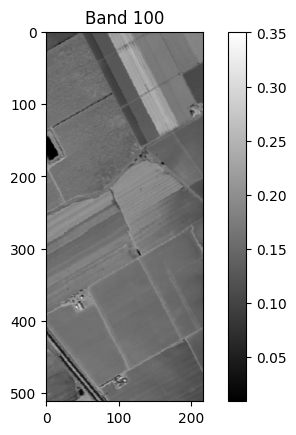

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `img` is your 3D image array with shape (512, 217, 204)

# Correcting the assumption about the array dimensions:
# img.shape = (samples, lines, bands)

# Selecting the 100th band from the image
# Given the structure, the band data is still the third dimension
band_to_plot = img[:, :, 99]  # 99 for the 100th band as indexing starts from 0

# Plotting the selected band
plt.imshow(band_to_plot, cmap='gray')  # Using 'gray' colormap for the band image
plt.colorbar()  # Adds a colorbar to represent the intensity scale of the band
plt.title('Band 100')  # Setting the title to indicate the band being plotted
plt.show()  # Display the plot

In [4]:
igm, label = dataset[1]

print(igm.shape)
print(label)

torch.Size([1, 204, 5, 5])
tensor(8)


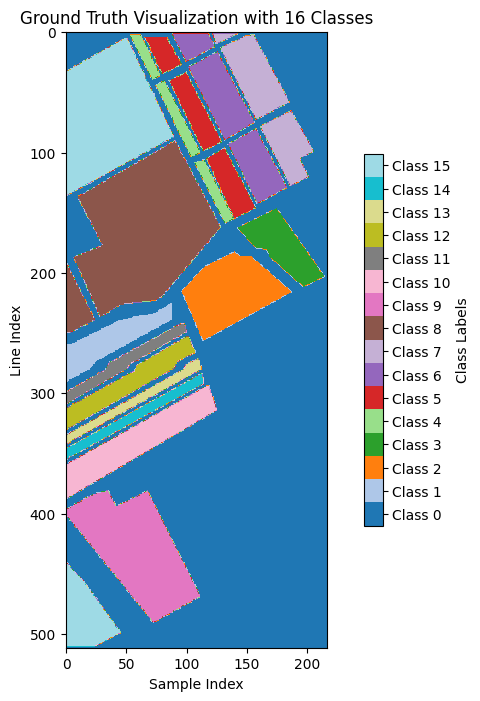

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `gt` is your 2D ground truth array with shape (512, 217)

# Creating a figure and axis for better control
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size for better clarity

# Creating a discrete colormap for your 16 classes
cmap = plt.get_cmap('tab20', 16)  # 'tab20' colormap with 16 distinct colors

# Plotting the ground truth array with the colormap
im = ax.imshow(gt, cmap=cmap, vmin=0, vmax=15)  # Ensure vmin and vmax match the range of your classes

# Creating a colorbar with a tick for each class
# Here, we specify the boundaries and ticks for clarity
cbar = fig.colorbar(im, ax=ax, boundaries=np.arange(-0.5, 16, 1), ticks=np.arange(0, 16), fraction=0.02, pad=0.04)
cbar.set_label('Class Labels')  # Labeling the color bar
cbar.set_ticklabels([f'Class {i}' for i in range(16)])  # Set custom tick labels

# Setting the title and axis labels for more informative presentation
ax.set_title('Ground Truth Visualization with 16 Classes')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Line Index')

plt.show()